In [ ]:
# library imports
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import random

In [2]:
# Helper functions and classes for user-level Transformer model
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Function to create sequences of user data for RNN input
def make_sequences(df, feature_cols):
    X_seqs = []
    y_labels = []
    
    # Group by user_id to create sequences
    for uid, g in df.groupby("user_id"):
        # Sort by created_utc to maintain temporal order
        g = g.sort_values("created_utc")
        # Extract feature columns and convert to tensor
        seq = torch.tensor(g[feature_cols].values, dtype=torch.float32)
        X_seqs.append(seq)
        # Depression or not
        y_labels.append(int(g["Depression"].max()))

    y_labels = torch.tensor(y_labels, dtype=torch.float32)

    return X_seqs, y_labels

# Collate function to pad sequences and create attention masks
def collate_fn(batch):
    seqs, labels = zip(*batch)

    padded = pad_sequence(seqs, batch_first=True)
    attention_mask = (padded.sum(dim=-1) != 0).long()
    labels = torch.tensor(labels, dtype=torch.float32)
    return padded, attention_mask, labels

# Custom Dataset class for user sequences
class UserSeqDataset(Dataset):
    def __init__(self, X_seqs, y):
        self.X = X_seqs
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer-based model for user classification
class TransformerUserClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, n_heads=4, n_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            batch_first=True,
            dropout=0.1
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Using mean pooling for classification
        self.cls_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, attention_mask):
        x = self.input_proj(x)
        src_key_padding_mask = (attention_mask == 0)
        out = self.encoder(x, src_key_padding_mask=src_key_padding_mask)

        out_masked = out.masked_fill(src_key_padding_mask.unsqueeze(-1), 0.0)
        valid_len = attention_mask.sum(dim=1).unsqueeze(-1)

        pooled = out_masked.sum(dim=1) / valid_len

        return self.cls_head(pooled).squeeze(1)
    
# Function to split data into training and validation sets at user level 
def user_split(df, val_ratio=0.15):
    users = df["user_id"].unique()
    labels = df.groupby("user_id")["Depression"].max()

    train_users, val_users = train_test_split(
        users,
        test_size=val_ratio,
        random_state=42,
        stratify=labels
    )

    df_train = df[df.user_id.isin(train_users)]
    df_val = df[df.user_id.isin(val_users)]

    return df_train, df_val

# Training function for the Transformer model
def train_model(model, train_loader, val_loader, epochs=30, lr=1e-4):
    device = next(model.parameters()).device
    pos_weight=torch.tensor([7.5], dtype=torch.float32).to(device)
    
    device = next(model.parameters()).device
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    best_val_loss = 1e10
    patience = 2
    patience_counter = 0

    for ep in range(1, epochs+1):
        model.train()
        total_train_loss = 0

        for x, mask, y in train_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x, mask)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, mask, y in val_loader:
                x, mask, y = x.to(device), mask.to(device), y.to(device)
                logits = model(x, mask)
                loss = criterion(logits, y)
                total_val_loss += loss.item()

        print(f"Epoch {ep}: Train Loss={total_train_loss/len(train_loader):.4f}, "
              f"Val Loss={total_val_loss/len(val_loader):.4f}")

        # Early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_state)

# Evaluation function for the Transformer model
def evaluate_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for x, mask, y in test_loader:
            x, mask = x.to(device), mask.to(device)
            logits = model(x, mask).cpu()
            all_logits.append(logits)
            all_labels.append(y)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    prob = torch.sigmoid(torch.tensor(logits)).numpy()
    pred = (prob >= 0.5).astype(int)

    print("==== Test Performance ====")
    print("Accuracy :", accuracy_score(labels, pred))
    print("Precision:", precision_score(labels, pred))
    print("Recall   :", recall_score(labels, pred))
    print("F1 Score :", f1_score(labels, pred))
    print("ROC-AUC  :", roc_auc_score(labels, prob))


In [3]:
# Load merged data
train=pd.read_pickle('../Features/final_training_dataset.pickle')
test=pd.read_pickle('../Features/final_testing_dataset.pickle')

# separate features 
#=============================================================================
cos_train=pd.read_pickle('../Features/cos_sim_features_train.pickle')
lsm_train=pd.read_pickle('../Features/LSM_features_train.pickle')
phq9_train=pd.read_pickle('../Features/PHQ9_features_train.pickle')
phq9_train=phq9_train.dropna(subset=['body']).copy()
re_train=pd.read_pickle('../Features/RE_features_train.pickle')
re_train=re_train.dropna(subset=['re']).copy()

#=============================================================================
cos_test=pd.read_pickle('../Features/cos_sim_features_test.pickle')
lsm_test=pd.read_pickle('../Features/LSM_features_test.pickle')
phq9_test=pd.read_pickle('../Features/PHQ9_features_test.pickle')
phq9_test=phq9_test.dropna(subset=['body']).copy()
re_test=pd.read_pickle('../Features/RE_features_test.pickle')
re_test=re_test.dropna(subset=['re']).copy()

print("featues:",train.columns.tolist())

featues: ['user_id', 'body', 'parent', 'created_utc', 'Depression', 'comment_id', 'submission_id', 'type', 'sim', 'max_sim_so_far', 'min_sim_so_far', 'max_gap_sim_so_far', 'delta_sim', 'rolling_std_sim', 'key', 'user_id_dup', 'body_dup', 'parent_dup', 'submission_id_dup', 'comment_id_dup', 'type_dup', 'Depression_dup', 'created_utc_dup', 'LSM_mean', 'social_mean', 'positive_mean', 'negative_mean', 'first_person_singular', 'second_person', 'third_person_singular', 'third_person_plural', 'cognitive_process', 'perceptual_process', 'LSM_mean_max_so_far', 'LSM_mean_min_so_far', 'LSM_mean_max_gap_so_far', 'LSM_mean_delta', 'LSM_mean_rolling_std', 'social_mean_max_so_far', 'social_mean_min_so_far', 'social_mean_max_gap_so_far', 'social_mean_delta', 'social_mean_rolling_std', 'positive_mean_max_so_far', 'positive_mean_min_so_far', 'positive_mean_max_gap_so_far', 'positive_mean_delta', 'positive_mean_rolling_std', 'negative_mean_max_so_far', 'negative_mean_min_so_far', 'negative_mean_max_gap_so

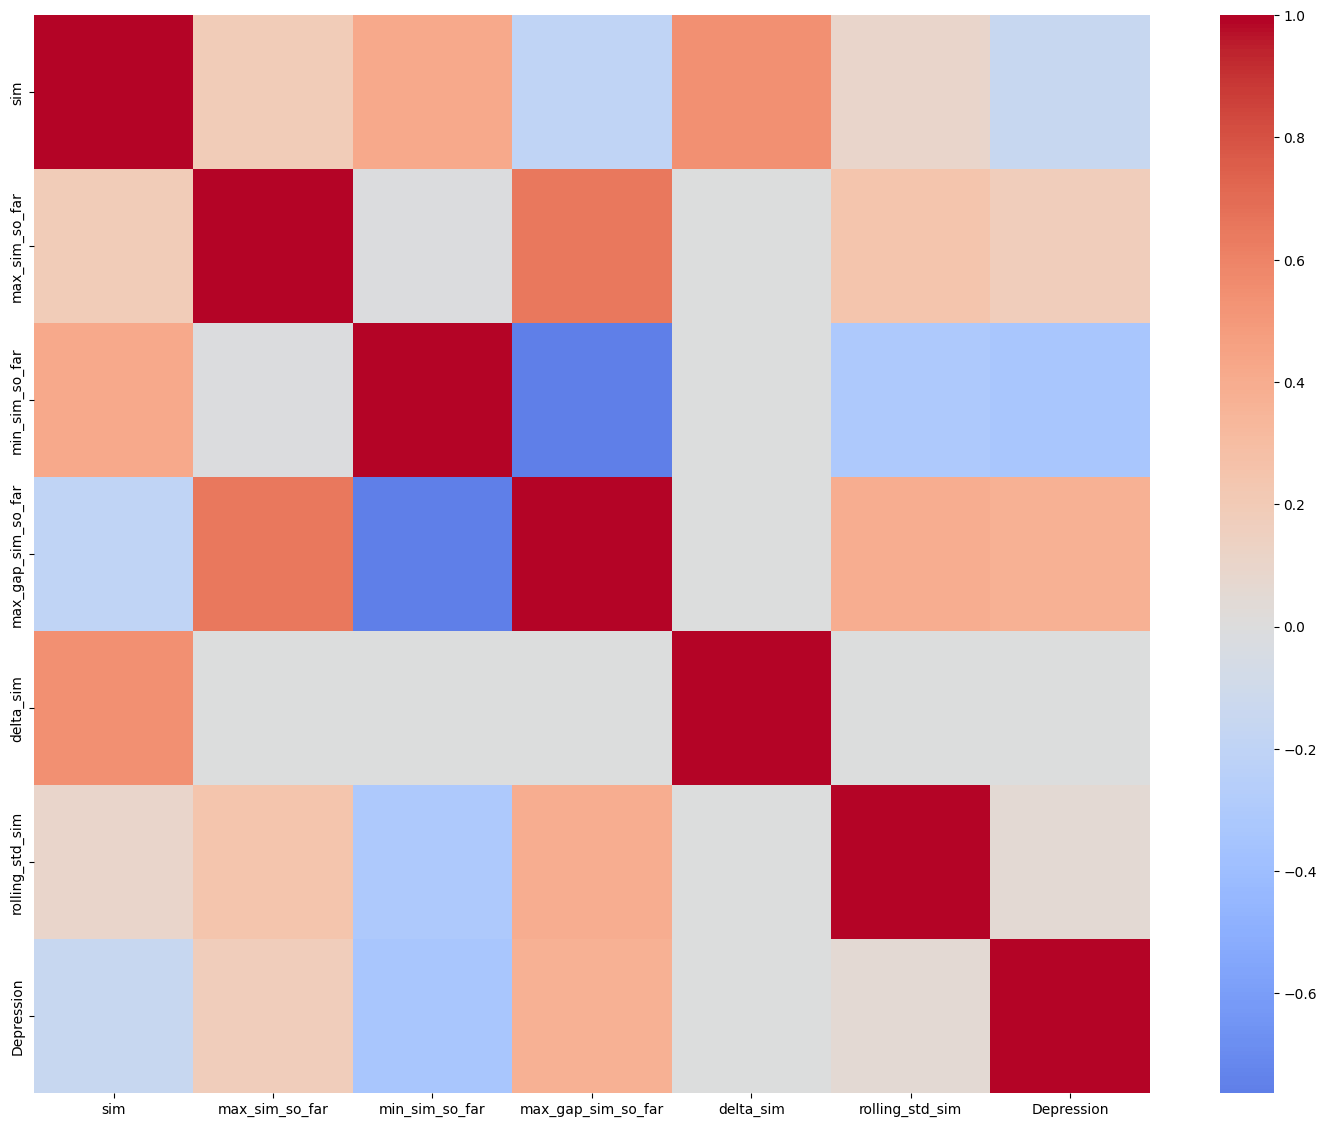

using features: ['sim', 'max_sim_so_far', 'min_sim_so_far', 'max_gap_sim_so_far', 'delta_sim', 'rolling_std_sim']
 Classification Report
              precision    recall  f1-score   support

         0.0     0.8760    0.8214    0.8478     30682
         1.0     0.6775    0.7635    0.7179     15080

    accuracy                         0.8023     45762
   macro avg     0.7768    0.7924    0.7829     45762
weighted avg     0.8106    0.8023    0.8050     45762

Accuracy     = 0.8023
Precision    = 0.6775 
Recall       = 0.7635 
F1.          = 0.7179 

=== COS feature selection ===
original: 6
useful features: 5
useful features: ['sim', 'min_sim_so_far', 'max_gap_sim_so_far', 'delta_sim', 'rolling_std_sim']


In [4]:
# Baseline for cosine similarity only (post level) - Logistic Regression
cos_cols = [
    'sim', 'max_sim_so_far', 'min_sim_so_far',
    'max_gap_sim_so_far', 'delta_sim', 'rolling_std_sim'
]

# correlation heatmap
corr = cos_train[cos_cols + ["Depression"]].corr()

plt.figure(figsize=(18,14))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

# features and labels
cos_X_train= cos_train[cos_cols].values
cos_y_train=cos_train['Depression'].values
cos_X_test  = cos_test[cos_cols].values
cos_y_test  = cos_test["Depression"].values

print("using features:",cos_cols)

# Model pipeline
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.1,        
        max_iter=500,
        n_jobs=-1
    ))
])

# predict
clf.fit(cos_X_train, cos_y_train)

cos_y_pred = clf.predict(cos_X_test)
cos_y_prob = clf.predict_proba(cos_X_test)[:, 1]

print(" Classification Report")
print(classification_report(cos_y_test, cos_y_pred, digits=4))

auc = roc_auc_score(cos_y_test, cos_y_prob)
acc  = accuracy_score(cos_y_test, cos_y_pred)
pre  = precision_score(cos_y_test, cos_y_pred, pos_label=1)
rec  = recall_score(cos_y_test, cos_y_pred, pos_label=1)
f1 = f1_score(cos_y_test, cos_y_pred, average="binary")   # 抑郁=1


print(f"Accuracy     = {acc:.4f}")
print(f"Precision    = {pre:.4f} ")
print(f"Recall       = {rec:.4f} ")
print(f"F1.          = {f1:.4f} ")


## check useful features
coef = clf.named_steps["logreg"].coef_[0]
non_zero_mask = np.abs(coef) > 1e-6
used_features = [c for c, m in zip(cos_cols, non_zero_mask) if m]

print(f"\n=== COS feature selection ===")
print(f"original: {len(cos_cols)}")
print(f"useful features: {len(used_features)}")
print("useful features:", used_features)

In [5]:
# Baseline for cosine similarity only (post level) - NN

# useful features
cos_cols=['sim', 'min_sim_so_far', 'max_gap_sim_so_far', 'delta_sim', 'rolling_std_sim']
# featyres and llabels
cos_X_train = torch.tensor(cos_train[cos_cols].values, dtype=torch.float32)
cos_y_train = torch.tensor(cos_train['Depression'].values, dtype=torch.float32)

cos_X_test  = torch.tensor(cos_test[cos_cols].values, dtype=torch.float32)
cos_y_test  = torch.tensor(cos_test['Depression'].values, dtype=torch.float32)

# Define NN model
class CosPostNN(nn.Module):
    def __init__(self,input_dim=5, hidden=64, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x).view(-1)
    
# Train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CosPostNN().to(device)

cos_X_train, cos_X_test = cos_X_train.to(device), cos_X_test.to(device)
cos_y_train, cos_y_test = cos_y_train.to(device), cos_y_test.to(device)

loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(50):
    model.train()
    pred = model(cos_X_train)
    loss = loss_fn(pred, cos_y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    

    if (epoch+1)%5==0:
        print(f"Epoch {epoch+1:02d} | loss={loss.item():.4f}")
        
# Evaluate the model
model.eval()
with torch.no_grad():
    prob = model(cos_X_test).cpu()
    pred = (prob>0.5).int()

post_f1 = f1_score(cos_y_test.cpu(), pred, average="binary")
print("\nPost-Level COS Neural F1 =", round(post_f1,4))


Epoch 05 | loss=0.6491
Epoch 10 | loss=0.5774
Epoch 15 | loss=0.5196
Epoch 20 | loss=0.4988
Epoch 25 | loss=0.4880
Epoch 30 | loss=0.4675
Epoch 35 | loss=0.4546
Epoch 40 | loss=0.4422
Epoch 45 | loss=0.4328
Epoch 50 | loss=0.4250

Post-Level COS Neural F1 = 0.6744


In [6]:
# User level prediction with Transformer -Cosine Similarity Only
# prepare data loaders
cos_test["created_utc"] = pd.to_datetime(cos_test["created_utc"])
cos_train["created_utc"] = pd.to_datetime(cos_train["created_utc"])

cos_train_user, cos_val_user= user_split(cos_train)

cos_X_train, cos_y_train = make_sequences(cos_train_user, cos_cols)
cos_X_val, cos_y_val = make_sequences(cos_val_user, cos_cols)
cos_X_test, cos_y_test = make_sequences(cos_test, cos_cols)

cos_train_loader = DataLoader(UserSeqDataset(cos_X_train, cos_y_train), batch_size=16, shuffle=False, collate_fn=collate_fn)
cos_val_loader   = DataLoader(UserSeqDataset(cos_X_val, cos_y_val), batch_size=16, shuffle=False, collate_fn=collate_fn)
cos_test_loader  = DataLoader(UserSeqDataset(cos_X_test, cos_y_test), batch_size=16, shuffle=False, collate_fn=collate_fn)

# initialize and train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerUserClassifier(input_dim=len(cos_cols)).to(device)
train_model(model, cos_train_loader, cos_val_loader, epochs=10)
#  Evaluate the model
evaluate_model(model, cos_test_loader)

/u50/zhanh279/miniconda3/envs/hongyi/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1: Train Loss=1.0949, Val Loss=0.9037
Epoch 2: Train Loss=0.9197, Val Loss=0.8419
Epoch 3: Train Loss=0.8069, Val Loss=0.7211
Epoch 4: Train Loss=0.6961, Val Loss=0.3181
Epoch 5: Train Loss=0.6806, Val Loss=0.4623
Epoch 6: Train Loss=0.7080, Val Loss=0.7442
Early stopping!
==== Test Performance ====
Accuracy : 0.5792349726775956
Precision: 0.20833333333333334
Recall   : 0.9523809523809523
F1 Score : 0.3418803418803419
ROC-AUC  : 0.9097589653145209


['user_id', 'body', 'type', 'Depression', 'created_utc', 'comment_id', 'parent_body', 'LSM_mean', 'social_mean', 'positive_mean', 'negative_mean', 'first_person_singular', 'second_person', 'third_person_singular', 'third_person_plural', 'cognitive_process', 'perceptual_process', 'LSM_mean_max_so_far', 'LSM_mean_min_so_far', 'LSM_mean_max_gap_so_far', 'LSM_mean_delta', 'LSM_mean_rolling_std', 'social_mean_max_so_far', 'social_mean_min_so_far', 'social_mean_max_gap_so_far', 'social_mean_delta', 'social_mean_rolling_std', 'positive_mean_max_so_far', 'positive_mean_min_so_far', 'positive_mean_max_gap_so_far', 'positive_mean_delta', 'positive_mean_rolling_std', 'negative_mean_max_so_far', 'negative_mean_min_so_far', 'negative_mean_max_gap_so_far', 'negative_mean_delta', 'negative_mean_rolling_std', 'first_person_singular_max_so_far', 'first_person_singular_min_so_far', 'first_person_singular_max_gap_so_far', 'first_person_singular_delta', 'first_person_singular_rolling_std', 'second_person_

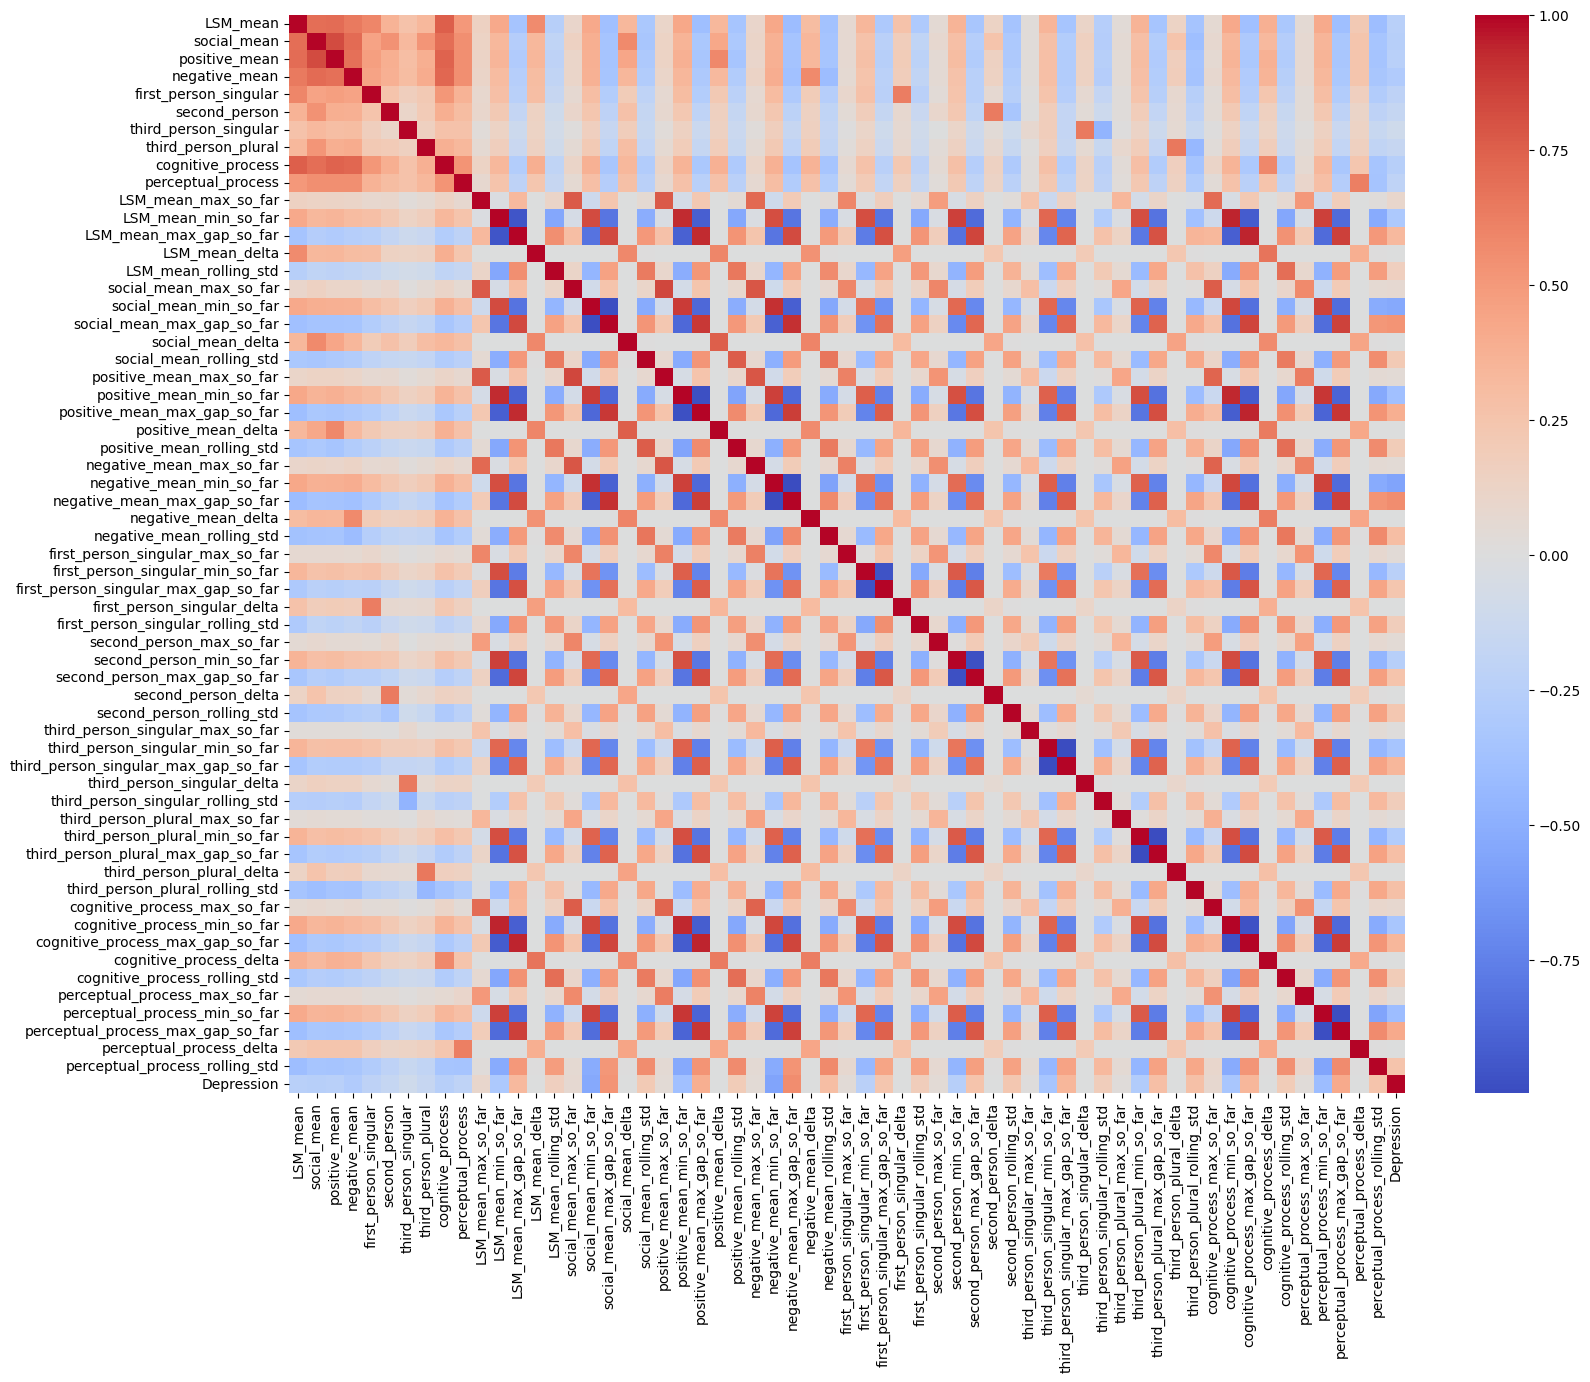

using features: ['LSM_mean', 'social_mean', 'positive_mean', 'negative_mean', 'first_person_singular', 'second_person', 'third_person_singular', 'third_person_plural', 'cognitive_process', 'perceptual_process', 'LSM_mean_max_so_far', 'LSM_mean_min_so_far', 'LSM_mean_max_gap_so_far', 'LSM_mean_delta', 'LSM_mean_rolling_std', 'social_mean_max_so_far', 'social_mean_min_so_far', 'social_mean_max_gap_so_far', 'social_mean_delta', 'social_mean_rolling_std', 'positive_mean_max_so_far', 'positive_mean_min_so_far', 'positive_mean_max_gap_so_far', 'positive_mean_delta', 'positive_mean_rolling_std', 'negative_mean_max_so_far', 'negative_mean_min_so_far', 'negative_mean_max_gap_so_far', 'negative_mean_delta', 'negative_mean_rolling_std', 'first_person_singular_max_so_far', 'first_person_singular_min_so_far', 'first_person_singular_max_gap_so_far', 'first_person_singular_delta', 'first_person_singular_rolling_std', 'second_person_max_so_far', 'second_person_min_so_far', 'second_person_max_gap_so_fa

/u50/zhanh279/miniconda3/envs/hongyi/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [7]:
# Baseline for LSM only (post level) - Logistic Regression
print(lsm_train.columns.tolist())
lsm_cols = [
    'LSM_mean', 'social_mean', 'positive_mean', 'negative_mean', 'first_person_singular', 
    'second_person', 'third_person_singular', 'third_person_plural', 'cognitive_process', 
    'perceptual_process', 'LSM_mean_max_so_far', 'LSM_mean_min_so_far', 'LSM_mean_max_gap_so_far', 
    'LSM_mean_delta', 'LSM_mean_rolling_std', 'social_mean_max_so_far', 'social_mean_min_so_far', 
    'social_mean_max_gap_so_far', 'social_mean_delta', 'social_mean_rolling_std', 'positive_mean_max_so_far', 
    'positive_mean_min_so_far', 'positive_mean_max_gap_so_far', 'positive_mean_delta', 'positive_mean_rolling_std', 
    'negative_mean_max_so_far', 'negative_mean_min_so_far', 'negative_mean_max_gap_so_far', 'negative_mean_delta', 
    'negative_mean_rolling_std', 'first_person_singular_max_so_far', 'first_person_singular_min_so_far',
    'first_person_singular_max_gap_so_far', 'first_person_singular_delta', 'first_person_singular_rolling_std', 
    'second_person_max_so_far', 'second_person_min_so_far', 'second_person_max_gap_so_far', 'second_person_delta', 
    'second_person_rolling_std', 'third_person_singular_max_so_far', 'third_person_singular_min_so_far', 
    'third_person_singular_max_gap_so_far', 'third_person_singular_delta', 'third_person_singular_rolling_std', 
    'third_person_plural_max_so_far', 'third_person_plural_min_so_far', 'third_person_plural_max_gap_so_far', 
    'third_person_plural_delta', 'third_person_plural_rolling_std', 'cognitive_process_max_so_far',
    'cognitive_process_min_so_far', 'cognitive_process_max_gap_so_far', 'cognitive_process_delta', 
    'cognitive_process_rolling_std', 'perceptual_process_max_so_far', 'perceptual_process_min_so_far', 
    'perceptual_process_max_gap_so_far', 'perceptual_process_delta', 'perceptual_process_rolling_std'
]

# correlation heatmap
corr = lsm_train[lsm_cols + ["Depression"]].corr()

plt.figure(figsize=(18,14))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

# features and labels
lsm_X_train= lsm_train[lsm_cols].values
lsm_y_train=lsm_train['Depression'].values
lsm_X_test  = lsm_test[lsm_cols].values
lsm_y_test  = lsm_test["Depression"].values

print("using features:",lsm_cols)

# Model pipeline
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.1,        
        max_iter=500,
        n_jobs=-1
    ))
])

# predict
clf.fit(lsm_X_train, lsm_y_train)

lsm_y_pred = clf.predict(lsm_X_test)
lsm_y_prob = clf.predict_proba(lsm_X_test)[:, 1]

print(" Classification Report")
print(classification_report(lsm_y_test, lsm_y_pred, digits=4))

auc = roc_auc_score(lsm_y_test, lsm_y_prob)
acc  = accuracy_score(lsm_y_test, lsm_y_pred)
pre  = precision_score(lsm_y_test, lsm_y_pred, pos_label=1)
rec  = recall_score(lsm_y_test, lsm_y_pred, pos_label=1)
f1 = f1_score(lsm_y_test, lsm_y_pred, average="binary")   # 抑郁=1


print(f"Accuracy     = {acc:.4f}")
print(f"Precision    = {pre:.4f} ")
print(f"Recall       = {rec:.4f} ")
print(f"F1.          = {f1:.4f} ")


## check useful features
coef = clf.named_steps["logreg"].coef_[0]
non_zero_mask = np.abs(coef) > 1e-6
used_features = [c for c, m in zip(lsm_cols, non_zero_mask) if m]

print(f"\n=== lsm feature selection ===")
print(f"original: {len(lsm_cols)}")
print(f"useful features: {len(used_features)}")
print("useful features:", used_features)

In [8]:
# Baseline for lsm only (post level) - NN

# featyres and llabels
lsm_X_train = torch.tensor(lsm_train[lsm_cols].values, dtype=torch.float32)
lsm_y_train = torch.tensor(lsm_train['Depression'].values, dtype=torch.float32)

lsm_X_test  = torch.tensor(lsm_test[lsm_cols].values, dtype=torch.float32)
lsm_y_test  = torch.tensor(lsm_test['Depression'].values, dtype=torch.float32)

# Define NN model
class LsmPostNN(nn.Module):
    def __init__(self,input_dim=60, hidden=64, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x).view(-1)
    
# Train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LsmPostNN().to(device)

lsm_X_train, lsm_X_test = lsm_X_train.to(device), lsm_X_test.to(device)
lsm_y_train, lsm_y_test = lsm_y_train.to(device), lsm_y_test.to(device)

loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(50):
    model.train()
    pred = model(lsm_X_train)
    loss = loss_fn(pred, lsm_y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    

    if (epoch+1)%5==0:
        print(f"Epoch {epoch+1:02d} | loss={loss.item():.4f}")
        
# Evaluate the model
model.eval()
with torch.no_grad():
    prob = model(lsm_X_test).cpu()
    pred = (prob>0.5).int()

post_f1 = f1_score(lsm_y_test.cpu(), pred, average="binary")
print("\nPost-Level lsm Neural F1 =", round(post_f1,4))


Epoch 05 | loss=0.5603
Epoch 10 | loss=0.5055
Epoch 15 | loss=0.4627
Epoch 20 | loss=0.4449
Epoch 25 | loss=0.4208
Epoch 30 | loss=0.4050
Epoch 35 | loss=0.3952
Epoch 40 | loss=0.3898
Epoch 45 | loss=0.3870
Epoch 50 | loss=0.3832

Post-Level lsm Neural F1 = 0.7254


In [9]:
# User level prediction with Transformer - lsm Only
# prepare data loaders
lsm_test["created_utc"] = pd.to_datetime(lsm_test["created_utc"])
lsm_train["created_utc"] = pd.to_datetime(lsm_train["created_utc"])

lsm_train_user, lsm_val_user= user_split(lsm_train)

lsm_X_train, lsm_y_train = make_sequences(lsm_train_user, lsm_cols)
lsm_X_val, lsm_y_val = make_sequences(lsm_val_user, lsm_cols)
lsm_X_test, lsm_y_test = make_sequences(lsm_test, lsm_cols)

lsm_train_loader = DataLoader(UserSeqDataset(lsm_X_train, lsm_y_train), batch_size=16, shuffle=False, collate_fn=collate_fn)
lsm_val_loader   = DataLoader(UserSeqDataset(lsm_X_val, lsm_y_val), batch_size=16, shuffle=False, collate_fn=collate_fn)
lsm_test_loader  = DataLoader(UserSeqDataset(lsm_X_test, lsm_y_test), batch_size=16, shuffle=False, collate_fn=collate_fn)

# initialize and train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerUserClassifier(input_dim=len(lsm_cols)).to(device)
train_model(model, lsm_train_loader, lsm_val_loader, epochs=10)
#  Evaluate the model
evaluate_model(model, lsm_test_loader)

Epoch 1: Train Loss=0.9731, Val Loss=0.7298
Epoch 2: Train Loss=0.7041, Val Loss=0.5514
Epoch 3: Train Loss=0.6144, Val Loss=0.6565
Epoch 4: Train Loss=0.5752, Val Loss=0.6843
Early stopping!
==== Test Performance ====
Accuracy : 0.7158469945355191
Precision: 0.28169014084507044
Recall   : 0.9523809523809523
F1 Score : 0.43478260869565216
ROC-AUC  : 0.9320987654320988


['user_id', 'target', 'type', 'title', 'body', 'created_utc', 'submission_id', 'parent_id', 'comment_id', 'Depression', 'parent', 'PHQ-9_archetype_scale.0.sim', 'PHQ-9_archetype_scale.1.sim', 'PHQ-9_archetype_scale.2.sim', 'PHQ-9_archetype_scale.3.sim', 'PHQ-9_archetype_scale.4.sim', 'PHQ-9_archetype_scale.5.sim', 'PHQ-9_archetype_scale.6.sim', 'PHQ-9_archetype_scale.7.sim', 'PHQ-9_archetype_scale.8.sim', 'phq_score', 'max_phq_so_far', 'min_phq_so_far', 'max_gap', 'delta_phq', 'rolling_std_phq', 'post_index', 'max_0_so_far', 'max_1_so_far', 'max_2_so_far', 'max_3_so_far', 'max_4_so_far', 'max_5_so_far', 'max_6_so_far', 'max_7_so_far', 'max_8_so_far']


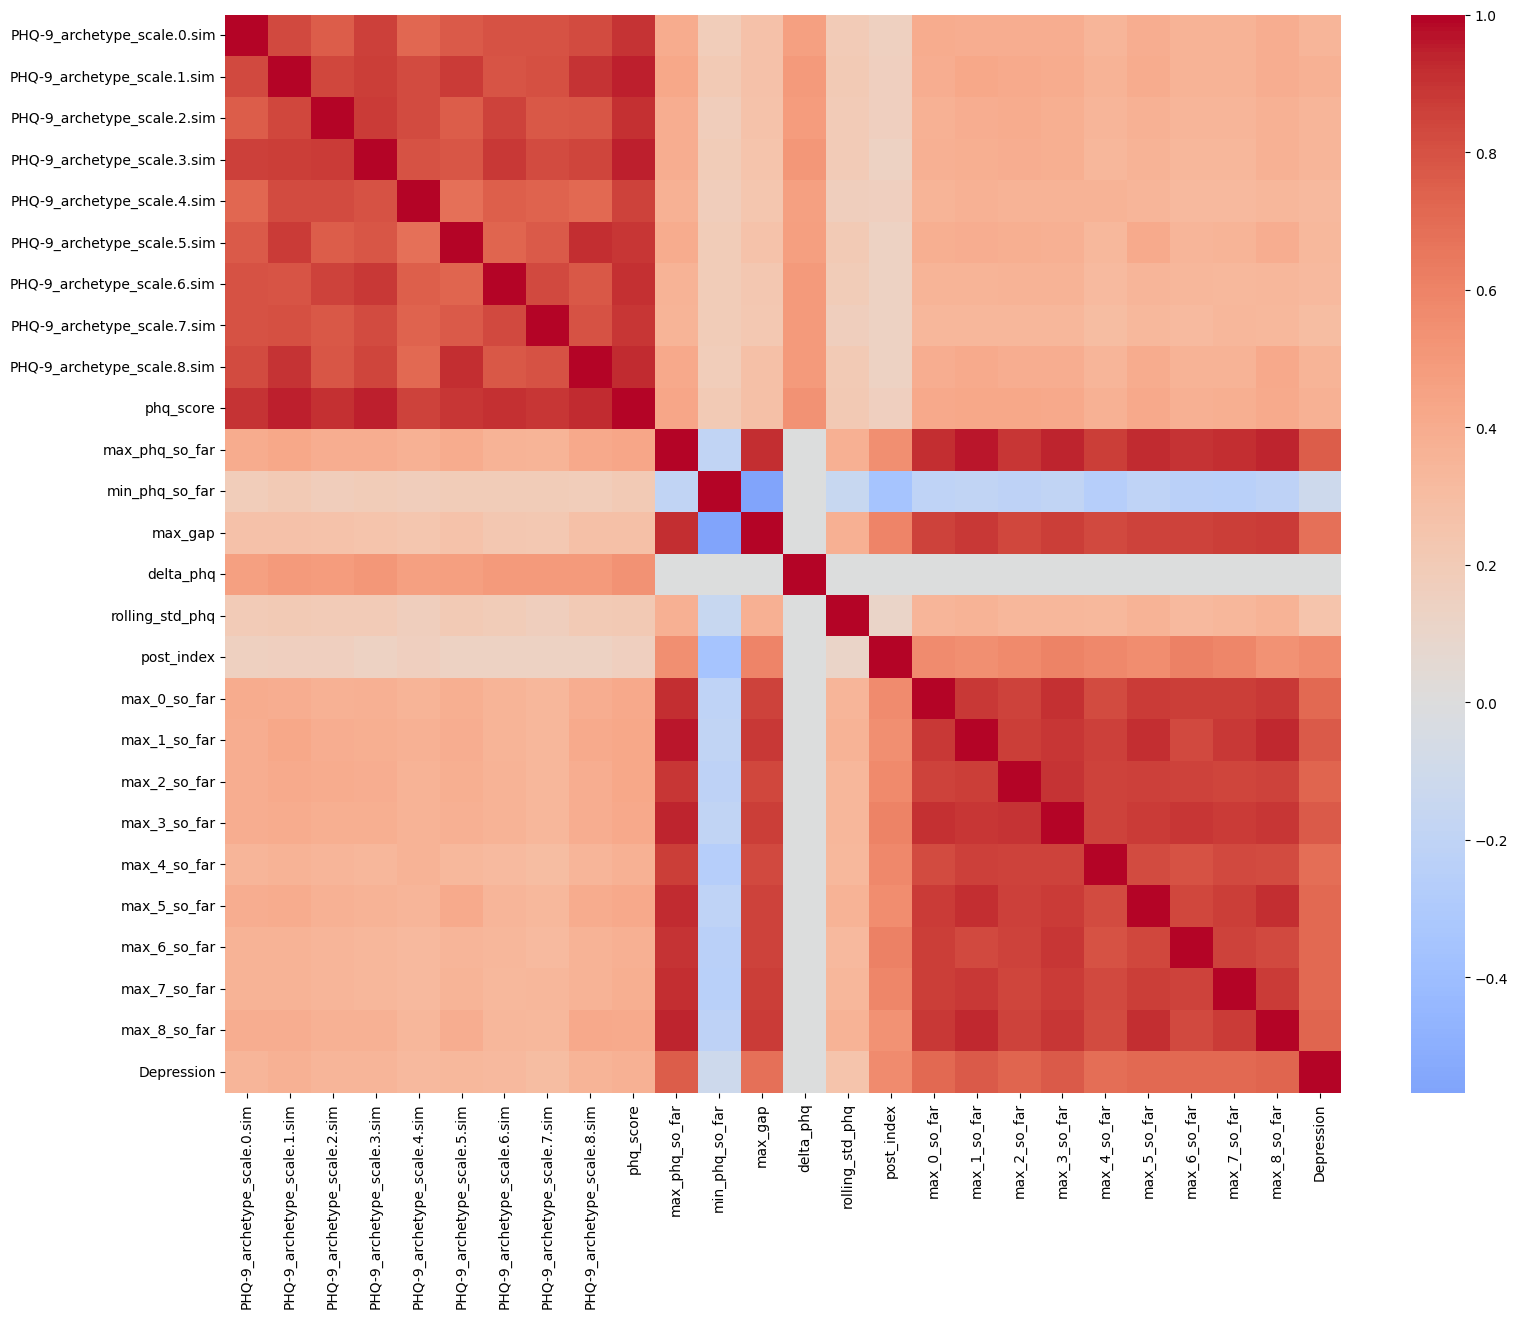

using features: ['PHQ-9_archetype_scale.0.sim', 'PHQ-9_archetype_scale.1.sim', 'PHQ-9_archetype_scale.2.sim', 'PHQ-9_archetype_scale.3.sim', 'PHQ-9_archetype_scale.4.sim', 'PHQ-9_archetype_scale.5.sim', 'PHQ-9_archetype_scale.6.sim', 'PHQ-9_archetype_scale.7.sim', 'PHQ-9_archetype_scale.8.sim', 'phq_score', 'max_phq_so_far', 'min_phq_so_far', 'max_gap', 'delta_phq', 'rolling_std_phq', 'post_index', 'max_0_so_far', 'max_1_so_far', 'max_2_so_far', 'max_3_so_far', 'max_4_so_far', 'max_5_so_far', 'max_6_so_far', 'max_7_so_far', 'max_8_so_far']
 Classification Report
              precision    recall  f1-score   support

         0.0     0.9250    0.8736    0.8986     23771
         1.0     0.8112    0.8846    0.8463     14590

    accuracy                         0.8778     38361
   macro avg     0.8681    0.8791    0.8725     38361
weighted avg     0.8817    0.8778    0.8787     38361

Accuracy     = 0.8778
Precision    = 0.8112 
Recall       = 0.8846 
F1.          = 0.8463 

=== phq9 fea

In [10]:
# Baseline for PGQ9 only (post level) - Logistic Regression
print(phq9_train.columns.tolist())
phq9_cols = ['PHQ-9_archetype_scale.0.sim', 'PHQ-9_archetype_scale.1.sim', 'PHQ-9_archetype_scale.2.sim', 
            'PHQ-9_archetype_scale.3.sim', 'PHQ-9_archetype_scale.4.sim', 'PHQ-9_archetype_scale.5.sim', 
            'PHQ-9_archetype_scale.6.sim', 'PHQ-9_archetype_scale.7.sim', 'PHQ-9_archetype_scale.8.sim', 
            'phq_score', 'max_phq_so_far', 'min_phq_so_far', 'max_gap', 'delta_phq', 'rolling_std_phq', 
            'post_index', 'max_0_so_far', 'max_1_so_far', 'max_2_so_far', 'max_3_so_far', 'max_4_so_far', 
            'max_5_so_far', 'max_6_so_far', 'max_7_so_far', 'max_8_so_far']

# correlation heatmap
corr = phq9_train[phq9_cols + ["Depression"]].corr()

plt.figure(figsize=(18,14))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

# features and labels
phq9_X_train= phq9_train[phq9_cols].values
phq9_y_train=phq9_train['Depression'].values
phq9_X_test  = phq9_test[phq9_cols].values
phq9_y_test  = phq9_test["Depression"].values

print("using features:",phq9_cols)

# Model pipeline
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.1,        
        max_iter=500,
        n_jobs=-1
    ))
])

# predict
clf.fit(phq9_X_train, phq9_y_train)

phq9_y_pred = clf.predict(phq9_X_test)
phq9_y_prob = clf.predict_proba(phq9_X_test)[:, 1]

print(" Classification Report")
print(classification_report(phq9_y_test, phq9_y_pred, digits=4))

auc = roc_auc_score(phq9_y_test, phq9_y_prob)
acc  = accuracy_score(phq9_y_test, phq9_y_pred)
pre  = precision_score(phq9_y_test, phq9_y_pred, pos_label=1)
rec  = recall_score(phq9_y_test, phq9_y_pred, pos_label=1)
f1 = f1_score(phq9_y_test, phq9_y_pred, average="binary")   


print(f"Accuracy     = {acc:.4f}")
print(f"Precision    = {pre:.4f} ")
print(f"Recall       = {rec:.4f} ")
print(f"F1.          = {f1:.4f} ")


## check useful features
coef = clf.named_steps["logreg"].coef_[0]
non_zero_mask = np.abs(coef) > 1e-6
used_features = [c for c, m in zip(phq9_cols, non_zero_mask) if m]

print(f"\n=== phq9 feature selection ===")
print(f"original: {len(phq9_cols)}")
print(f"useful features: {len(used_features)}")
print("useful features:", used_features)

In [11]:
# Baseline for phq9 only (post level) - NN

# featyres and llabels
phq9_X_train = torch.tensor(phq9_train[phq9_cols].values, dtype=torch.float32)
phq9_y_train = torch.tensor(phq9_train['Depression'].values, dtype=torch.float32)

phq9_X_test  = torch.tensor(phq9_test[phq9_cols].values, dtype=torch.float32)
phq9_y_test  = torch.tensor(phq9_test['Depression'].values, dtype=torch.float32)

# Define NN model
class Phq9PostNN(nn.Module):
    def __init__(self,input_dim=len(phq9_cols), hidden=64, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x).view(-1)
    
# Train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Phq9PostNN().to(device)

phq9_X_train, phq9_X_test = phq9_X_train.to(device), phq9_X_test.to(device)
phq9_y_train, phq9_y_test = phq9_y_train.to(device), phq9_y_test.to(device)

loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(50):
    model.train()
    pred = model(phq9_X_train)
    loss = loss_fn(pred, phq9_y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    

    if (epoch+1)%5==0:
        print(f"Epoch {epoch+1:02d} | loss={loss.item():.4f}")
        
# Evaluate the model
model.eval()
with torch.no_grad():
    prob = model(phq9_X_test).cpu()
    pred = (prob>0.5).int()

post_f1 = f1_score(phq9_y_test.cpu(), pred, average="binary")
print("\nPost-Level phq9 Neural F1 =", round(post_f1,4))


Epoch 05 | loss=16.8371
Epoch 10 | loss=3.9846
Epoch 15 | loss=0.7754
Epoch 20 | loss=0.4754
Epoch 25 | loss=0.4247
Epoch 30 | loss=0.4010
Epoch 35 | loss=0.3964
Epoch 40 | loss=0.3757
Epoch 45 | loss=0.3651
Epoch 50 | loss=0.3530

Post-Level phq9 Neural F1 = 0.6886


In [12]:
# User level prediction with Transformer - phq9 Only
# prepare data loaders
phq9_test["created_utc"] = pd.to_datetime(phq9_test["created_utc"])
phq9_train["created_utc"] = pd.to_datetime(phq9_train["created_utc"])

phq9_train_user, phq9_val_user= user_split(phq9_train)

phq9_X_train, phq9_y_train = make_sequences(phq9_train_user, phq9_cols)
phq9_X_val, phq9_y_val = make_sequences(phq9_val_user, phq9_cols)
phq9_X_test, phq9_y_test = make_sequences(phq9_test, phq9_cols)

phq9_train_loader = DataLoader(UserSeqDataset(phq9_X_train, phq9_y_train), batch_size=16, shuffle=False, collate_fn=collate_fn)
phq9_val_loader   = DataLoader(UserSeqDataset(phq9_X_val, phq9_y_val), batch_size=16, shuffle=False, collate_fn=collate_fn)
phq9_test_loader  = DataLoader(UserSeqDataset(phq9_X_test, phq9_y_test), batch_size=16, shuffle=False, collate_fn=collate_fn)

# initialize and train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerUserClassifier(input_dim=len(phq9_cols)).to(device)
train_model(model, phq9_train_loader, phq9_val_loader)
#  Evaluate the model
evaluate_model(model, phq9_test_loader)

Epoch 1: Train Loss=1.1445, Val Loss=1.1286
Epoch 2: Train Loss=1.0761, Val Loss=1.1025
Epoch 3: Train Loss=1.0695, Val Loss=1.0307
Epoch 4: Train Loss=0.8623, Val Loss=0.8136
Epoch 5: Train Loss=0.7534, Val Loss=0.7250
Epoch 6: Train Loss=0.7232, Val Loss=0.7028
Epoch 7: Train Loss=0.7791, Val Loss=0.7660
Epoch 8: Train Loss=0.7289, Val Loss=0.7509
Early stopping!
==== Test Performance ====
Accuracy : 0.8370786516853933
Precision: 0.38235294117647056
Recall   : 0.6190476190476191
F1 Score : 0.4727272727272727
ROC-AUC  : 0.8019411586290568


['user_id', 'target', 'type', 'title', 'body', 'created_utc', 'submission_id', 'parent_id', 'comment_id', 'Depression', 'parent', 'loss_dep0', 'loss_dep1', 're', 'max_re_so_far', 'min_re_so_far', 'max_gap_re_so_far', 'delta_re', 'rolling_std_re']


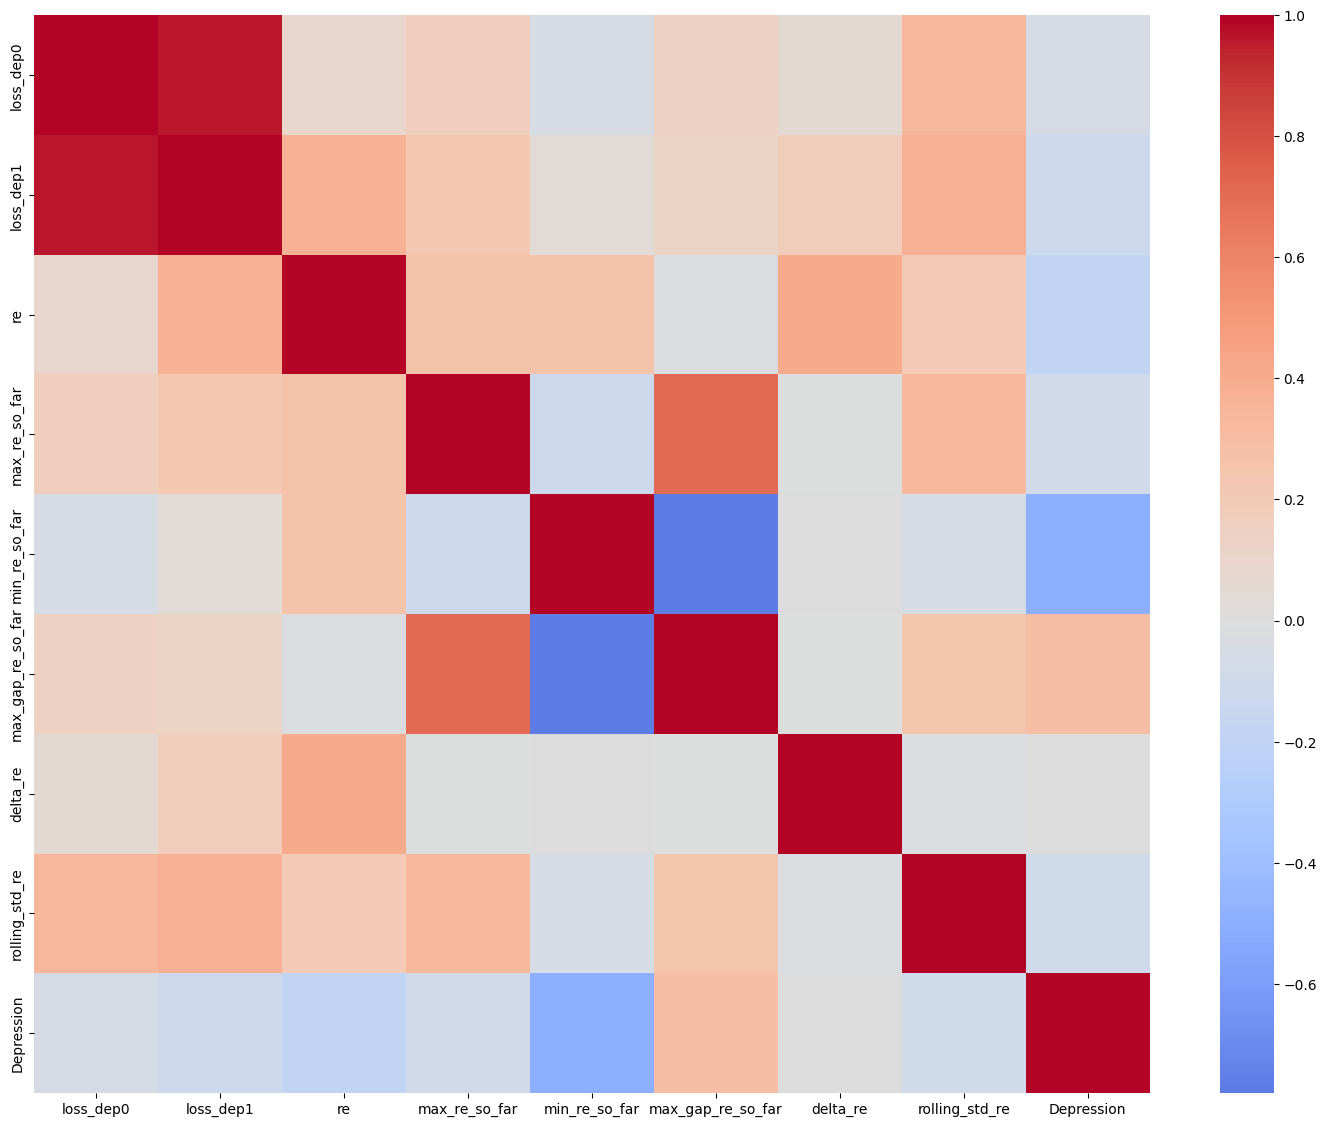

using features: ['loss_dep0', 'loss_dep1', 're', 'max_re_so_far', 'min_re_so_far', 'max_gap_re_so_far', 'delta_re', 'rolling_std_re']
 Classification Report
              precision    recall  f1-score   support

         0.0     0.7785    0.6973    0.7357     23476
         1.0     0.5804    0.6786    0.6257     14487

    accuracy                         0.6901     37963
   macro avg     0.6795    0.6879    0.6807     37963
weighted avg     0.7029    0.6901    0.6937     37963

Accuracy     = 0.6901
Precision    = 0.5804 
Recall       = 0.6786 
F1.          = 0.6257 

=== re feature selection ===
original: 8
useful features: 7
useful features: ['loss_dep1', 're', 'max_re_so_far', 'min_re_so_far', 'max_gap_re_so_far', 'delta_re', 'rolling_std_re']


/u50/zhanh279/miniconda3/envs/hongyi/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Baseline for RE only (post level) - Logistic Regression
print(re_train.columns.tolist())
re_cols = ['loss_dep0', 'loss_dep1', 're', 'max_re_so_far', 'min_re_so_far', 'max_gap_re_so_far', 'delta_re', 'rolling_std_re']

# correlation heatmap
corr = re_train[re_cols + ["Depression"]].corr()

plt.figure(figsize=(18,14))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

# features and labels
re_X_train= re_train[re_cols].values
re_y_train=re_train['Depression'].values
re_X_test  = re_test[re_cols].values
re_y_test  = re_test["Depression"].values

print("using features:",re_cols)

# Model pipeline
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.5,        
        max_iter=500,
        n_jobs=-1
    ))
])

# predict
clf.fit(re_X_train, re_y_train)

re_y_pred = clf.predict(re_X_test)
re_y_prob = clf.predict_proba(re_X_test)[:, 1]

print(" Classification Report")
print(classification_report(re_y_test, re_y_pred, digits=4))

auc = roc_auc_score(re_y_test, re_y_prob)
acc  = accuracy_score(re_y_test, re_y_pred)
pre  = precision_score(re_y_test, re_y_pred, pos_label=1)
rec  = recall_score(re_y_test, re_y_pred, pos_label=1)
f1 = f1_score(re_y_test, re_y_pred, average="binary")   


print(f"Accuracy     = {acc:.4f}")
print(f"Precision    = {pre:.4f} ")
print(f"Recall       = {rec:.4f} ")
print(f"F1.          = {f1:.4f} ")


## check useful features
coef = clf.named_steps["logreg"].coef_[0]
non_zero_mask = np.abs(coef) > 1e-6
used_features = [c for c, m in zip(re_cols, non_zero_mask) if m]

print(f"\n=== re feature selection ===")
print(f"original: {len(re_cols)}")
print(f"useful features: {len(used_features)}")
print("useful features:", used_features)

In [37]:
# Baseline for RE only (post level) - NN

# featyres and llabels
re_X_train = torch.tensor(re_train[re_cols].values, dtype=torch.float32)
re_y_train = torch.tensor(re_train['Depression'].values, dtype=torch.float32)

re_X_test  = torch.tensor(re_test[re_cols].values, dtype=torch.float32)
re_y_test  = torch.tensor(re_test['Depression'].values, dtype=torch.float32)

# Define NN model
class rePostNN(nn.Module):
    def __init__(self,input_dim=len(re_cols), hidden=64, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x).view(-1)
    
# Train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = rePostNN().to(device)

re_X_train, re_X_test = re_X_train.to(device), re_X_test.to(device)
re_y_train, re_y_test = re_y_train.to(device), re_y_test.to(device)

loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(50):
    model.train()
    pred = model(re_X_train)
    loss = loss_fn(pred, re_y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    

    if (epoch+1)%5==0:
        print(f"Epoch {epoch+1:02d} | loss={loss.item():.4f}")
        
# Evaluate the model
model.eval()
with torch.no_grad():
    prob = model(re_X_test).cpu()
    pred = (prob>0.5).int()

post_f1 = f1_score(re_y_test.cpu(), pred, average="binary")
print("\nPost-Level re Neural F1 =", round(post_f1,4))


Epoch 05 | loss=0.6012
Epoch 10 | loss=0.4582
Epoch 15 | loss=0.4316
Epoch 20 | loss=0.4136
Epoch 25 | loss=0.3978
Epoch 30 | loss=0.3944
Epoch 35 | loss=0.3844
Epoch 40 | loss=0.3808
Epoch 45 | loss=0.3737
Epoch 50 | loss=0.3694

Post-Level re Neural F1 = 0.6341


In [32]:
# User level prediction with Transformer - RE Only
# prepare data loaders
re_test["created_utc"] = pd.to_datetime(re_test["created_utc"])
re_train["created_utc"] = pd.to_datetime(re_train["created_utc"])

re_train_user, re_val_user= user_split(re_train)

re_X_train, re_y_train = make_sequences(re_train_user, re_cols)
re_X_val, re_y_val = make_sequences(re_val_user, re_cols)
re_X_test, re_y_test = make_sequences(re_test, re_cols)

re_train_loader = DataLoader(UserSeqDataset(re_X_train, re_y_train), batch_size=16, shuffle=True, collate_fn=collate_fn)
re_val_loader   = DataLoader(UserSeqDataset(re_X_val, re_y_val), batch_size=16, shuffle=False, collate_fn=collate_fn)
re_test_loader  = DataLoader(UserSeqDataset(re_X_test, re_y_test), batch_size=16, shuffle=False, collate_fn=collate_fn)

# initialize and train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerUserClassifier(input_dim=len(re_cols)).to(device)
train_model(model, re_train_loader, re_val_loader, epochs=10)
#  Evaluate the model
evaluate_model(model, re_test_loader)

Epoch 1: Train Loss=0.4203, Val Loss=0.3259
Epoch 2: Train Loss=0.2835, Val Loss=0.2458
Epoch 3: Train Loss=0.2329, Val Loss=0.2435
Epoch 4: Train Loss=0.2264, Val Loss=0.2921
Epoch 5: Train Loss=0.2443, Val Loss=0.2572
Early stopping!
==== Test Performance ====
Accuracy : 0.8314606741573034
Precision: 0.3902439024390244
Recall   : 0.7619047619047619
F1 Score : 0.5161290322580645
ROC-AUC  : 0.8450106157112526
